In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv').drop(columns='id')
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [4]:
def downcast_df(df):
    for col in df.select_dtypes(include=["int", "float"]).columns:
        if df[col].dtype == "int64" or df[col].dtype == "int32":
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif df[col].dtype == "float64" or df[col].dtype == "float32":
            df[col] = pd.to_numeric(df[col], downcast="float")
    return df

# Example usage
train = downcast_df(train)
train.dtypes

MonsoonIntensity                      int8
TopographyDrainage                    int8
RiverManagement                       int8
Deforestation                         int8
Urbanization                          int8
ClimateChange                         int8
DamsQuality                           int8
Siltation                             int8
AgriculturalPractices                 int8
Encroachments                         int8
IneffectiveDisasterPreparedness       int8
DrainageSystems                       int8
CoastalVulnerability                  int8
Landslides                            int8
Watersheds                            int8
DeterioratingInfrastructure           int8
PopulationScore                       int8
WetlandLoss                           int8
InadequatePlanning                    int8
PoliticalFactors                      int8
FloodProbability                   float32
dtype: object

<Axes: >

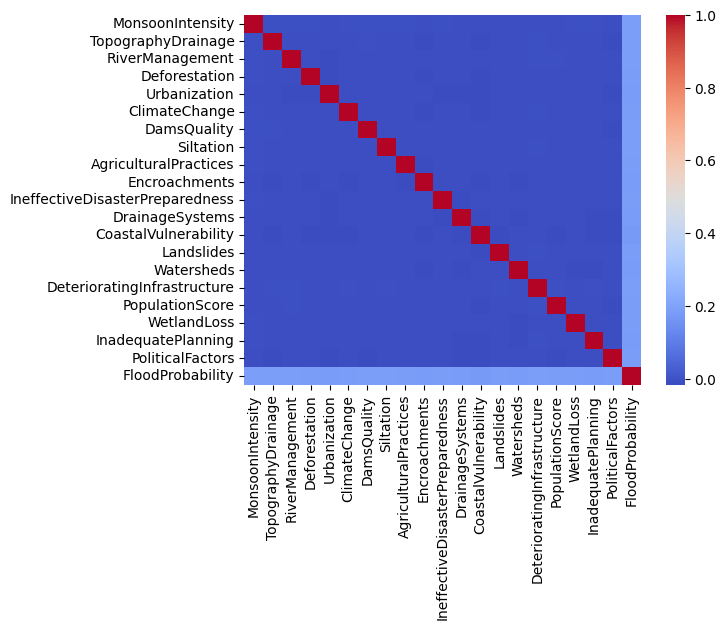

In [5]:
sns.heatmap(train.corr(), cmap='coolwarm')

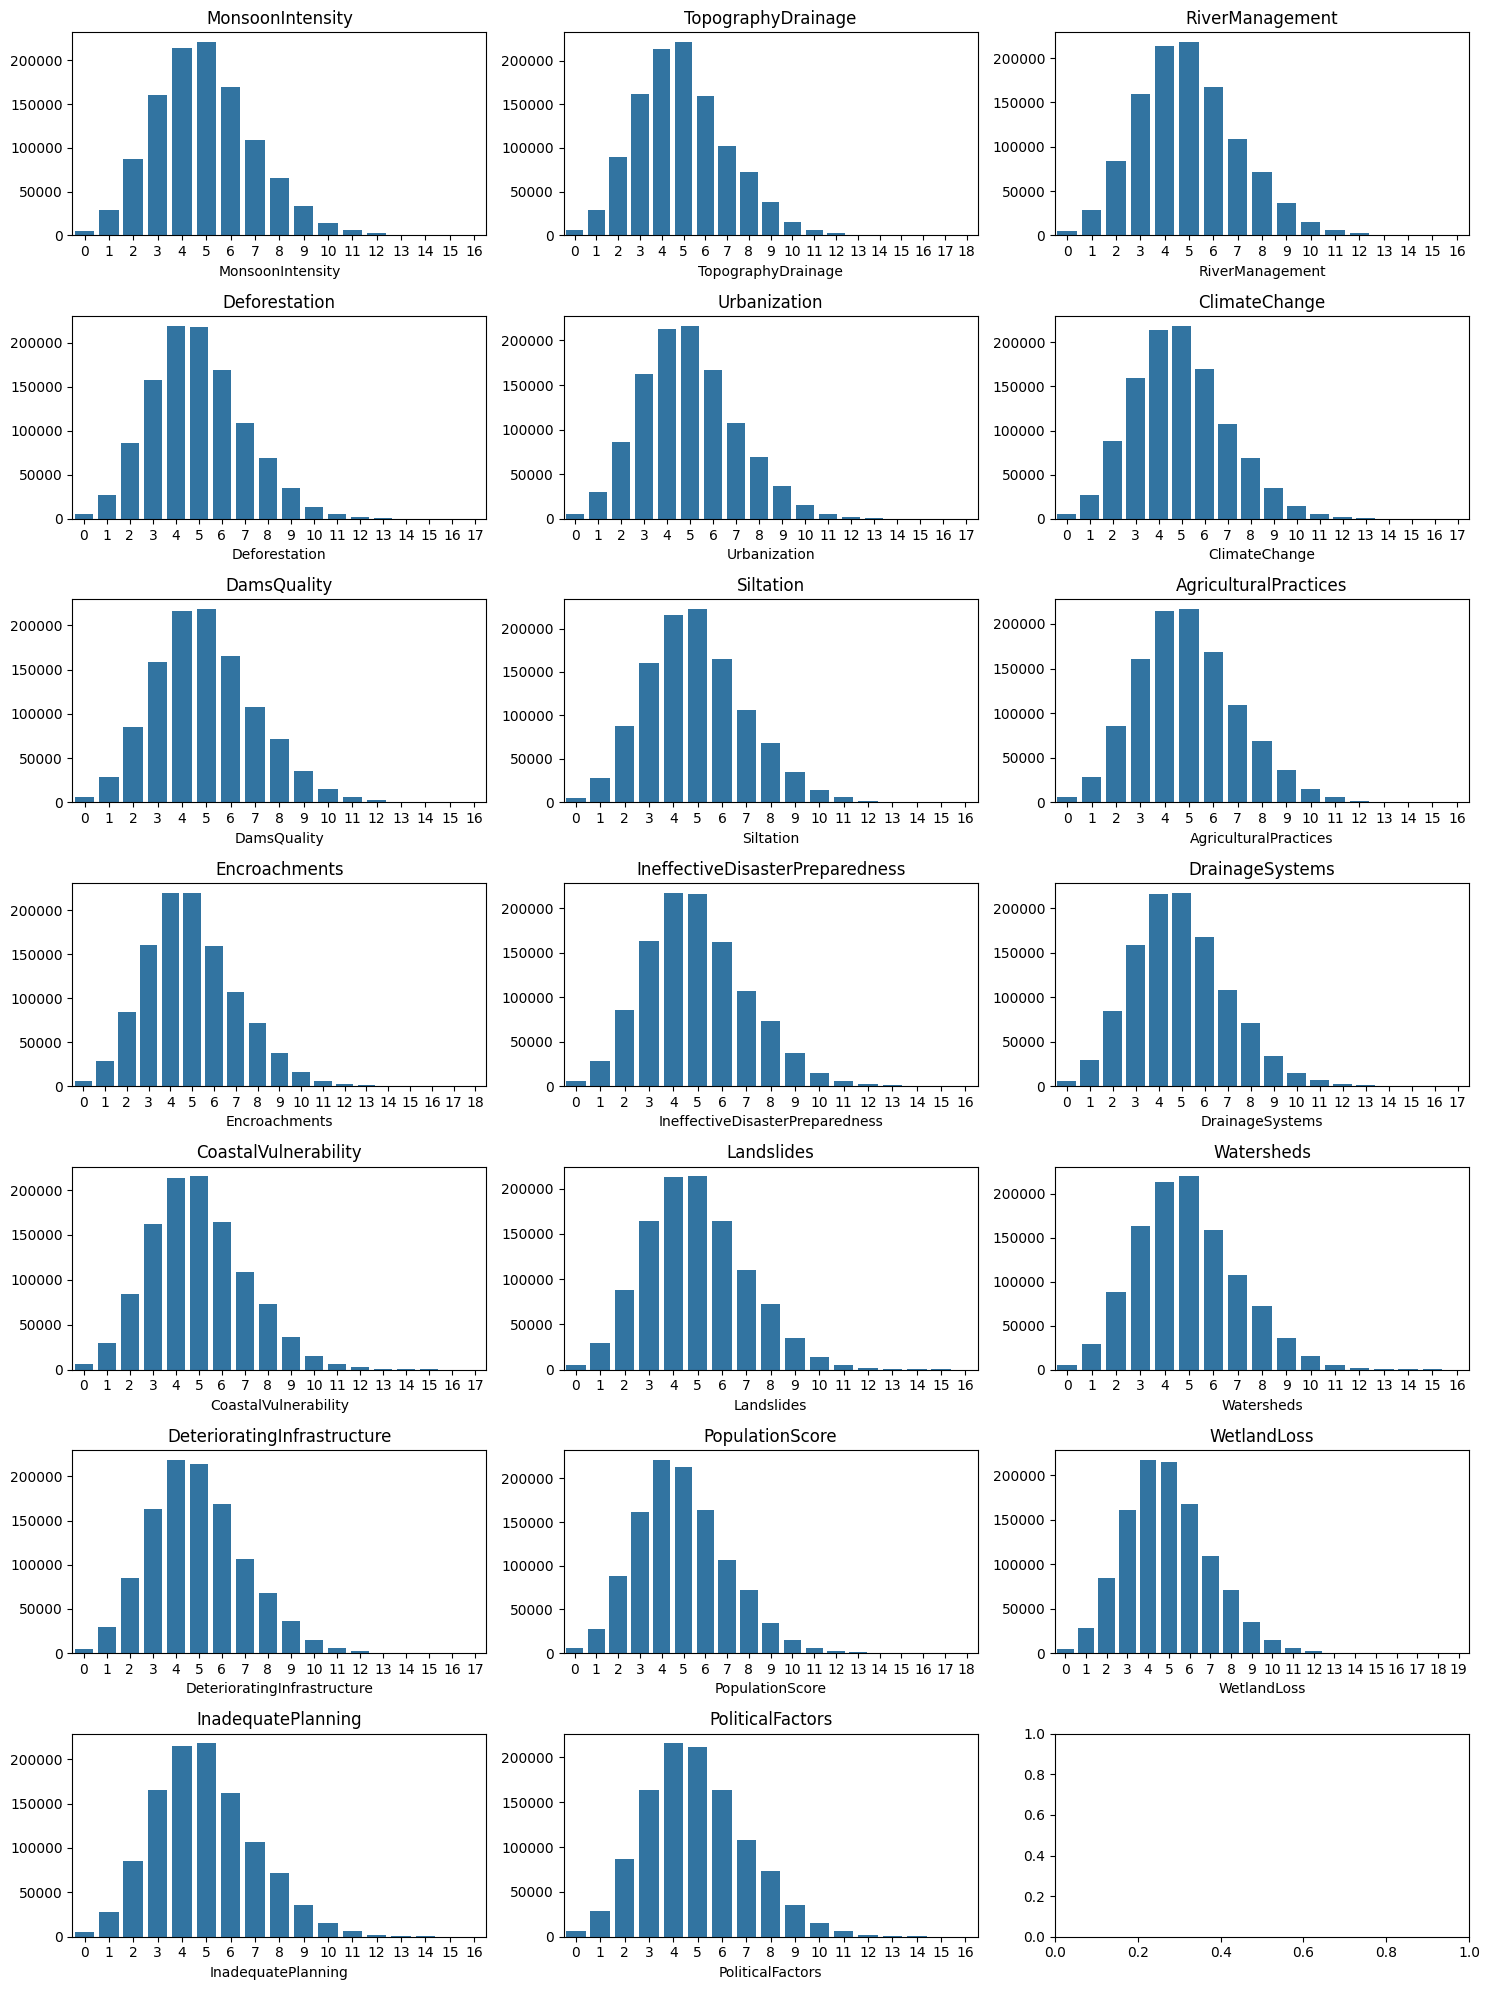

In [11]:
# Visualize counts of everything
ncols = 3
fig, axs = plt.subplots(len(train.columns)//ncols, ncols, figsize=(15,20))
axs = axs.flatten()
for i, col in enumerate(train.columns):
    if col == 'FloodProbability': continue

    counts = train[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax = axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

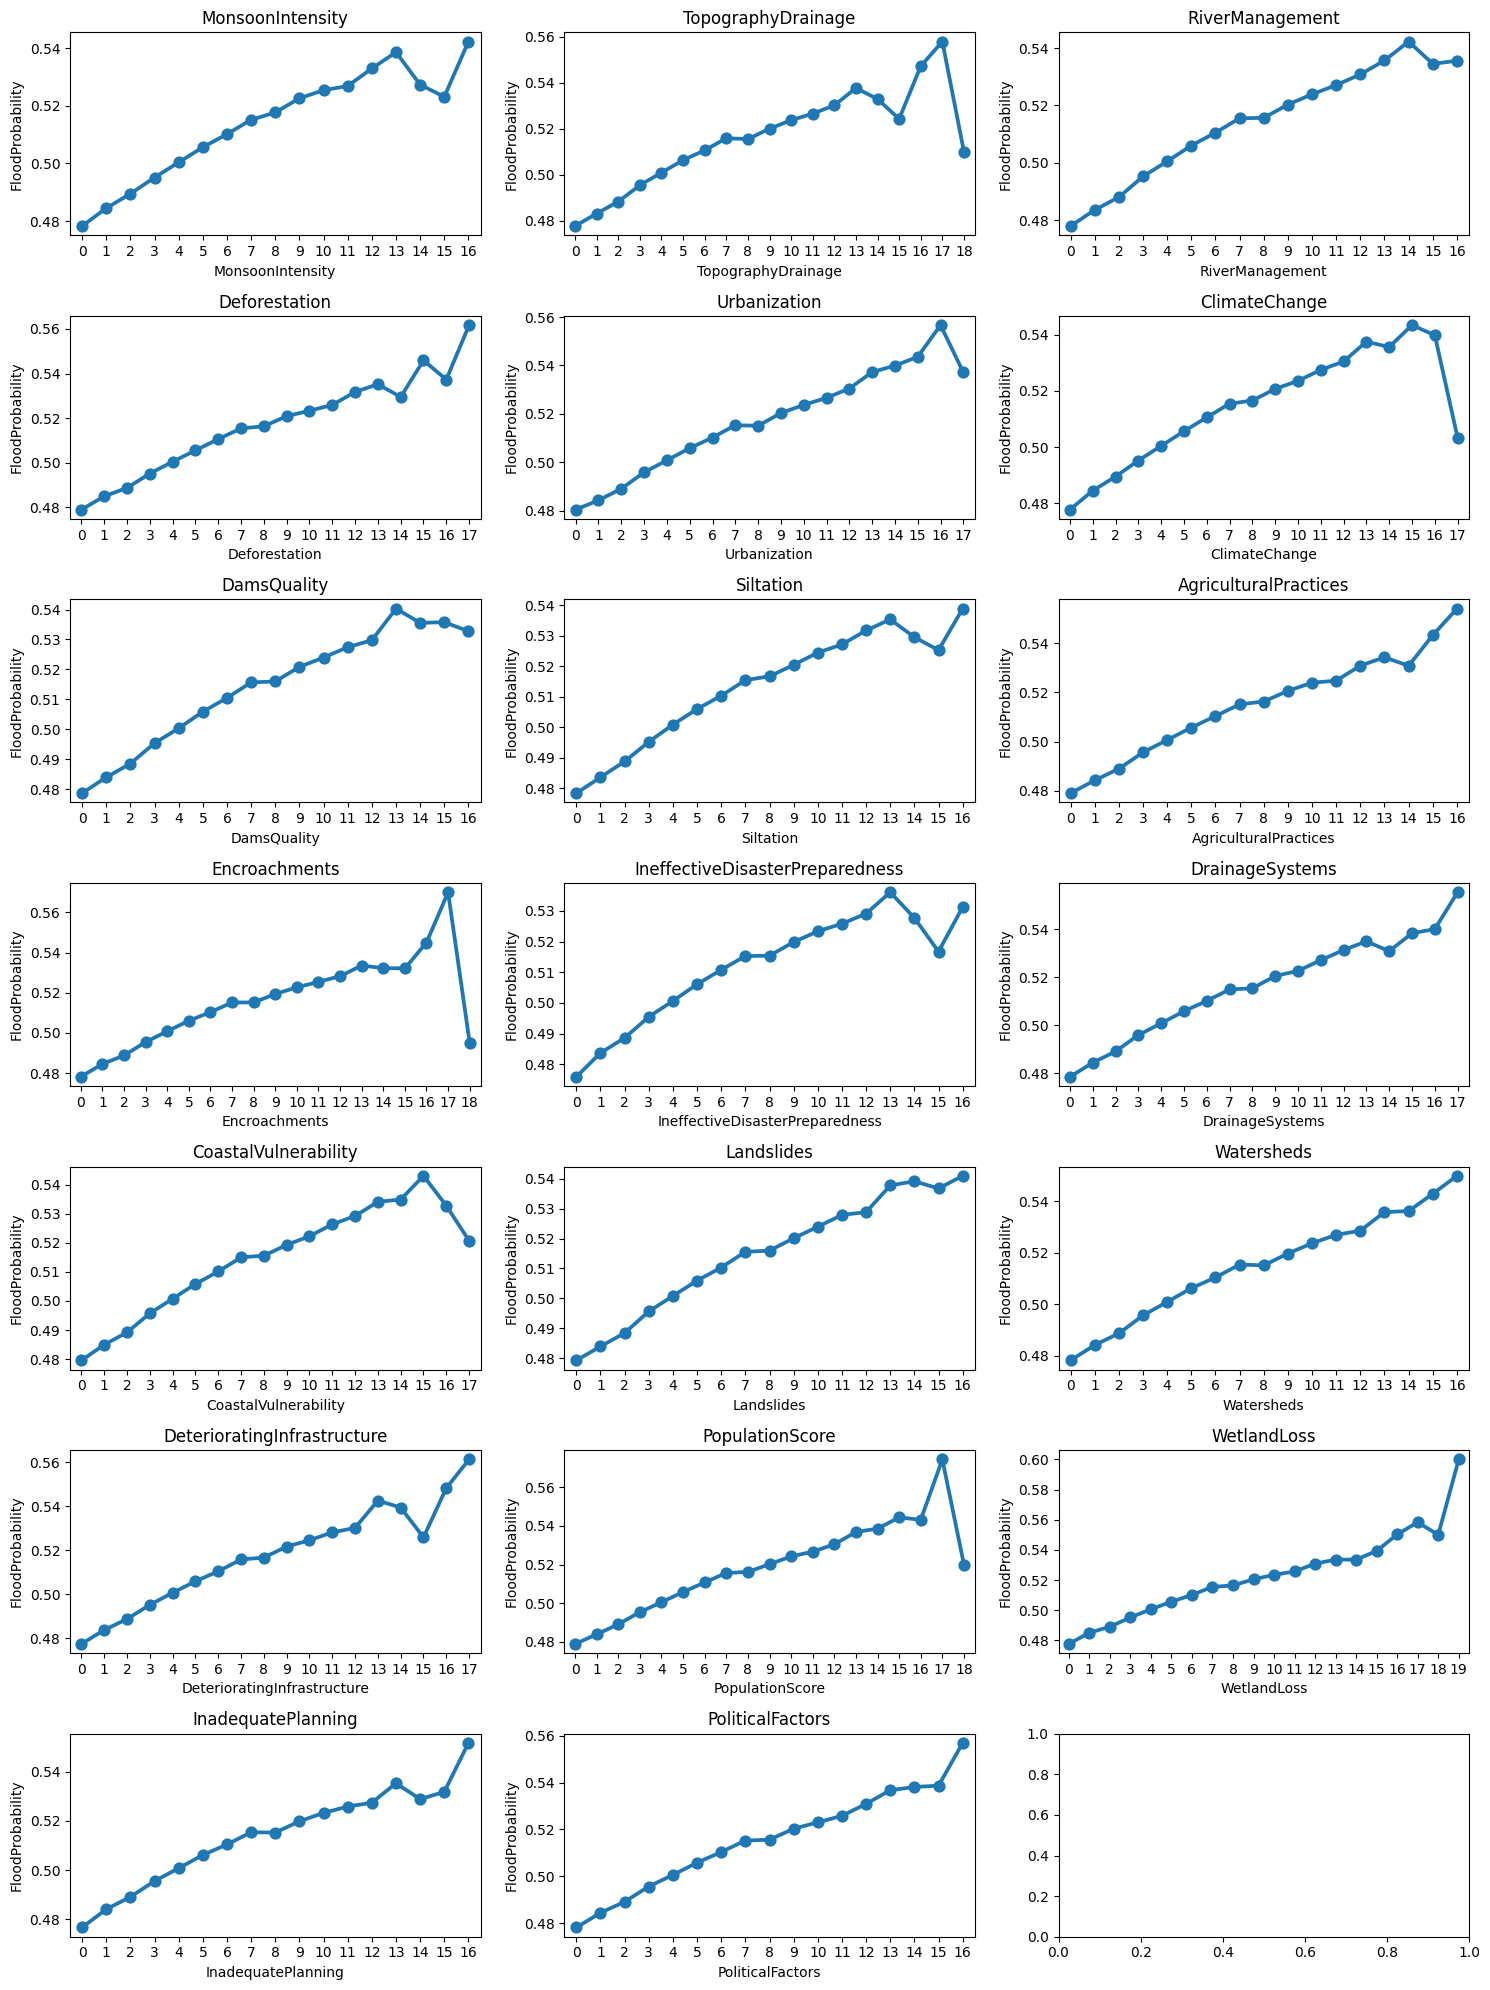

In [23]:
# For each value, I want to see the distribution of Flood Probability
ncols = 3
fig, axs = plt.subplots(len(train.columns)//ncols, ncols, figsize=(15,20))
axs = axs.flatten()
for i, col in enumerate(train.columns):
    if col == 'FloodProbability': continue

    sns.pointplot(x=train[col], y=train['FloodProbability'], ax = axs[i], errorbar=None)
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

In [17]:
# List most correlated pairs
corr_matrix = train.drop(columns='FloodProbability').corr().stack().reset_index()
corr_matrix.columns = ['col1', 'col2', 'correlation']
corr_matrix = corr_matrix[corr_matrix['col1'] < corr_matrix['col2']]
corr_matrix['abs_correlation'] = np.abs(corr_matrix['correlation'])
corr_matrix = corr_matrix.sort_values(by='abs_correlation', ascending=False)
corr_matrix

,col1,col2,correlation,abs_correlation
249,CoastalVulnerability,Encroachments,-0.016203,0.016203
244,CoastalVulnerability,Urbanization,-0.014497,0.014497
258,CoastalVulnerability,InadequatePlanning,-0.014006,0.014006
194,Encroachments,Watersheds,-0.013542,0.013542
251,CoastalVulnerability,DrainageSystems,-0.013467,0.013467
...,...,...,...,...
322,PopulationScore,RiverManagement,-0.006727,0.006727
301,DeterioratingInfrastructure,TopographyDrainage,-0.006628,0.006628
115,ClimateChange,DeterioratingInfrastructure,-0.006324,0.006324
307,DeterioratingInfrastructure,Siltation,-0.006312,0.006312


In [31]:
# Any hiddenness? Like are they correlated in some weird way

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

def mutual_info_matrix(df):
    df = df.drop(columns='FloodProbability')
    pairs = [(df.columns[i], df.columns[j]) for i in range(df.shape[1]) for j in range(i + 1, df.shape[1])]
    
    mi_scores = []
    for col1, col2 in tqdm(pairs, desc="Computing Mutual Information", unit="pair"):
        mi = mutual_info_score(df[col1], df[col2])
        mi_scores.append((col1, col2, mi))

    # Convert to DataFrame
    mi_df = pd.DataFrame(mi_scores, columns=["col1", "col2", "mutual_info"])
    
    # Sort by mutual information score in descending order
    mi_df = mi_df.sort_values(by="mutual_info", ascending=False).reset_index(drop=True)
    
    return mi_df

mutual_df = mutual_info_matrix(train)
mutual_df

Computing Mutual Information: 100%|██████████| 190/190 [00:23<00:00,  8.03pair/s]


,col1,col2,mutual_info
0,Watersheds,InadequatePlanning,0.000612
1,IneffectiveDisasterPreparedness,Watersheds,0.000602
2,TopographyDrainage,Watersheds,0.000578
3,IneffectiveDisasterPreparedness,InadequatePlanning,0.000577
4,Encroachments,CoastalVulnerability,0.000543
...,...,...,...
185,DamsQuality,AgriculturalPractices,0.000333
186,AgriculturalPractices,DeterioratingInfrastructure,0.000331
187,MonsoonIntensity,DrainageSystems,0.000322
188,DeterioratingInfrastructure,PopulationScore,0.000317


In [ ]:
# What to do next: try multi LR???
